# Machine Learning Trading System
This notebook creates a machine learnig based trading system with the following steps:
- Data download
- Feature engineering
- XGBoost classifier with tuning
- Confidence-filtered long/short strategy
- Risk-weighted portfolio and backtest

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

plt.style.use("seaborn-whitegrid")

os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("data/predicted", exist_ok=True)


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3701067505.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
# Tickers (Expanded)
TICKERS = [
    'EURUSD=X', 'USDJPY=X', 'GBPUSD=X',
    'AUDUSD=X', 'USDCAD=X', 'NZDUSD=X',
    'CHFUSD=X', 'GC=F', 'SI=F', 'CL=F', 'SPY', 'GLD'
]


In [3]:
# Download Data
def download_data(start='2015-01-01', end='2024-12-31'):
    for ticker in TICKERS:
        safe_name = ticker.replace("=", "").replace("/", "_")
        path = f"data/raw/{safe_name}.csv"
        print(f"Downloading {ticker}...")
        df = yf.download(ticker, start=start, end=end, auto_adjust=True)
        if df.empty:
            print(f"⚠️ No data for {ticker}")
            continue
        df.to_csv(path)
        print(f"✅ Saved: {path}")

download_data()


[*********************100%***********************]  1 of 1 completed


✅ Saved: data/raw/EURUSDX.csv


[*********************100%***********************]  1 of 1 completed


✅ Saved: data/raw/USDJPYX.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ Saved: data/raw/GBPUSDX.csv



[*********************100%***********************]  1 of 1 completed

✅ Saved: data/raw/AUDUSDX.csv


✅ Saved: data/raw/USDCADX.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Saved: data/raw/NZDUSDX.csv
✅ Saved: data/raw/CHFUSDX.csv


[*********************100%***********************]  1 of 1 completed


✅ Saved: data/raw/GCF.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Saved: data/raw/SIF.csv
✅ Saved: data/raw/CLF.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ Saved: data/raw/SPY.csv
✅ Saved: data/raw/GLD.csv


In [4]:
# Feature Engineering
def compute_features(df, windows=[5, 10, 21, 63]):
    df = df.copy()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    for w in windows:
        df[f'mom_{w}'] = df['log_return'].rolling(w).sum()
        df[f'vol_{w}'] = df['log_return'].rolling(w).std()
        df[f'zscore_{w}'] = (df['Close'] - df['Close'].rolling(w).mean()) / df['Close'].rolling(w).std()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ema_up = up.ewm(span=14).mean()
    ema_down = down.ewm(span=14).mean()
    rs = ema_up / (ema_down + 1e-6)
    df['rsi_14'] = 100 - (100 / (1 + rs))
    return df.dropna()

for file in os.listdir("data/raw"):
    if file.endswith(".csv"):
        df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_dates=True)
        df = df.apply(pd.to_numeric, errors="coerce")
        df_feat = compute_features(df)
        df_feat.to_csv(f"data/processed/{file}")
        print(f"✅ Features saved: {file}")


/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3054912228.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_dates=True)
/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3054912228.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_dates=True)
/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3054912228.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_d

✅ Features saved: AUDUSDX.csv
✅ Features saved: USDJPYX.csv
✅ Features saved: NZDUSDX.csv
✅ Features saved: CLF.csv
✅ Features saved: GLD.csv


/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3054912228.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_dates=True)


✅ Features saved: CHFUSDX.csv


/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3054912228.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_dates=True)
/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3054912228.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_dates=True)
/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3054912228.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_d

✅ Features saved: SIF.csv
✅ Features saved: GCF.csv
✅ Features saved: USDCADX.csv
✅ Features saved: GBPUSDX.csv
✅ Features saved: SPY.csv


/var/folders/3j/nt60m26d5nj7vpq6x70vhbgh0000gn/T/ipykernel_25824/3054912228.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"data/raw/{file}", index_col=0, parse_dates=True)


✅ Features saved: EURUSDX.csv


In [5]:
# Classification Model
FEATURE_COLUMNS = [
    'mom_5', 'mom_10', 'mom_21', 'mom_63',
    'vol_5', 'vol_10', 'vol_21', 'vol_63',
    'zscore_5', 'zscore_10', 'zscore_21', 'zscore_63',
    'rsi_14'
]

def train_predict_classifier(df, train_size=0.8):
    df = df.copy()
    df['target'] = (df['log_return'].shift(-1) > 0).astype(int)
    df = df.dropna()
    X = df[FEATURE_COLUMNS].astype(float)
    y = df['target'].astype(int)
    mask = X.notnull().all(axis=1) & y.notnull()
    X, y = X[mask], y[mask]
    split = int(len(df) * train_size)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    param_grid = {'max_depth': [2, 3], 'learning_rate': [0.05, 0.1], 'n_estimators': [50, 100]}
    grid = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_proba = best_model.predict_proba(X_test)[:, 1]
    df.loc[X_test.index, 'pred_prob'] = y_proba
    print(f"🧠 Best Params: {grid.best_params_}")
    return df

for file in os.listdir("data/processed"):
    if file.endswith(".csv"):
        df = pd.read_csv(f"data/processed/{file}", index_col=0, parse_dates=True)
        df = df.apply(pd.to_numeric, errors="coerce")
        df_pred = train_predict_classifier(df)
        df_pred.to_csv(f"data/predicted/{file}")
        print(f"✅ Prediction saved: {file}")


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
✅ Prediction saved: AUDUSDX.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
✅ Prediction saved: USDJPYX.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
✅ Prediction saved: NZDUSDX.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
✅ Prediction saved: CLF.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
✅ Prediction saved: GLD.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
✅ Prediction saved: CHFUSDX.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
✅ Prediction saved: SIF.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
✅ Prediction saved: GCF.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
✅ Prediction saved: USDCADX.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
✅ Prediction saved: GBPUSDX.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
✅ Prediction saved: SPY.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

🧠 Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
✅ Prediction saved: EURUSDX.csv


/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakoblutz/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

In [6]:
# Backtest with Confidence Filtering
def load_predictions(path='data/predicted'):
    asset_dfs = {}
    for file in os.listdir(path):
        if file.endswith('.csv'):
            symbol = file.replace('.csv', '')
            df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True)
            if 'pred_prob' in df.columns and 'log_return' in df.columns:
                df = df[['pred_prob', 'log_return']].dropna()
                asset_dfs[symbol] = df
    return asset_dfs

def construct_portfolio(asset_dfs, threshold=0.6, vol_window=20):
    all_dates = sorted(set().union(*[df.index for df in asset_dfs.values()]))
    daily_returns = []

    for date in all_dates:
        preds = []
        for symbol, df in asset_dfs.items():
            if date not in df.index:
                continue
            try:
                prob = df.at[date, 'pred_prob']
                ret = df.at[date, 'log_return']
                vol = df['log_return'].rolling(vol_window).std().loc[date]
                weight = 1 / vol if vol > 0 else 0
                if prob > threshold:
                    preds.append((symbol, 1, ret, weight))  # Long
                elif prob < 1 - threshold:
                    preds.append((symbol, -1, ret, weight))  # Short
            except:
                continue

        df_day = pd.DataFrame(preds, columns=['symbol', 'signal', 'ret', 'weight']).dropna()
        if df_day.empty:
            continue
        df_day['norm_weight'] = df_day['weight'] / df_day['weight'].sum()
        df_day['pnl'] = df_day['ret'] * df_day['signal'] * df_day['norm_weight']
        pnl = df_day['pnl'].sum()
        daily_returns.append({'date': date, 'return': pnl})

    returns = pd.DataFrame(daily_returns)
    returns.index = pd.to_datetime(returns['date'])
    returns.drop(columns='date', inplace=True)
    return returns



Backtest Results
-----------------------------
Sharpe Ratio : -0.29
Max Drawdown : -20.03%
Total Return : -5.86%
CAGR         : -4.20%


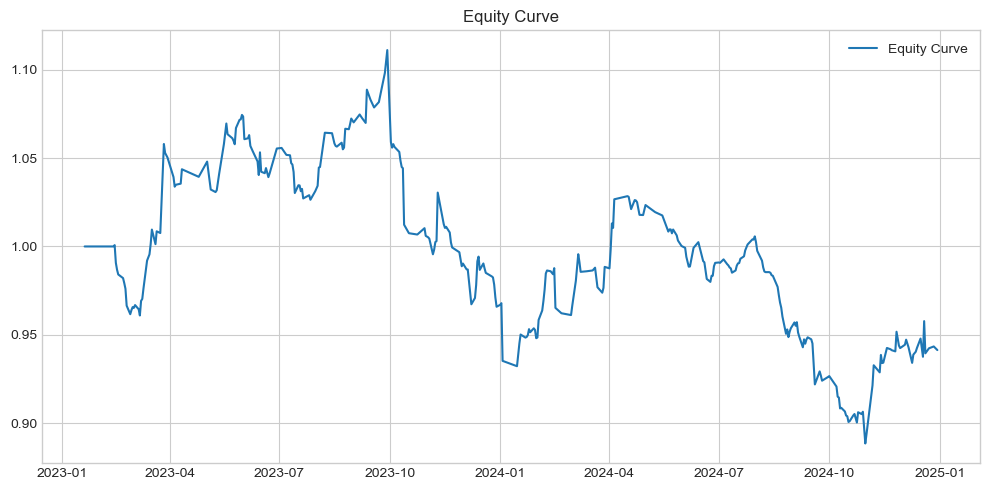

In [7]:
# Performance Analysis
def analyze_performance(returns):
    returns['equity'] = (1 + returns['return']).cumprod()
    sharpe = returns['return'].mean() / returns['return'].std() * np.sqrt(252)
    max_dd = (returns['equity'] / returns['equity'].cummax() - 1).min()
    total_return = returns['equity'].iloc[-1] - 1
    cagr = (returns['equity'].iloc[-1])**(252 / len(returns)) - 1

    print(f"\nBacktest Results")
    print(f"-----------------------------")
    print(f"Sharpe Ratio : {sharpe:.2f}")
    print(f"Max Drawdown : {max_dd:.2%}")
    print(f"Total Return : {total_return:.2%}")
    print(f"CAGR         : {cagr:.2%}")

    plt.figure(figsize=(10, 5))
    plt.plot(returns.index, returns['equity'], label='Equity Curve')
    plt.title("Equity Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

assets = load_predictions()
returns = construct_portfolio(assets, threshold=0.6)
analyze_performance(returns)
